In [45]:
import tensorflow as tf
import pandas            as pd
import tensorflow        as tf  
import numpy             as np
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models          import Sequential
from tensorflow.keras.layers          import Dense,LSTM,Bidirectional

from numpy.random   import seed



In [54]:
# 确保结果尽可能重现

seed(1)
tf.random.set_seed(1)

# 设置相关参数
n_timestamp  = 40    # 时间戳
n_epochs     = 20    # 训练轮数
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================
model_type = 1

In [1]:
# 导入tushare
import tushare as ts

In [5]:
pro=ts.get_hist_data('600848')

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [ ]:

# 初始化pro接口
#pro = ts.pro_api('84a7d42ba53be1e345b15650d19116113087ad5440320b4c6b7b6c67')

# 拉取数据
data = pro.daily(**{
    "ts_code": '600848.sh',
    "trade_date": "",
    "start_date": "",
    "end_date": "",
    "offset": "",
    "limit": ""
}, fields=[
    "trade_date",
    "open",
    "close",
    "high",
    "low",
    "vol",
    "ts_code"
])


In [4]:
print(data)
data.to_csv("stock600848.csv")

             open   high  close    low     volume  price_change  p_change  \
date                                                                        
2021-10-15  15.38  15.53  15.39  15.32   37514.89          0.02      0.13   
2021-10-14  15.46  15.46  15.37  15.23   37009.49          0.01      0.07   
2021-10-13  15.13  15.48  15.36  15.12   43195.69          0.22      1.45   
2021-10-12  15.28  15.34  15.14  15.08   42036.80         -0.12     -0.79   
2021-10-11  15.13  15.34  15.26  15.13   33682.97          0.14      0.93   
...           ...    ...    ...    ...        ...           ...       ...   
2019-04-23  36.14  38.81  37.49  35.61  203943.80          1.73      4.84   
2019-04-22  35.30  36.66  35.76  35.30  126570.22          0.29      0.82   
2019-04-19  35.88  36.29  35.47  34.49   99508.10         -0.53     -1.47   
2019-04-18  35.52  36.30  36.00  35.22   81878.63          0.17      0.47   
2019-04-17  35.96  36.67  35.83  35.20  118798.04         -0.37     -1.02   

In [ ]:

data.iloc[0:4813-300,3]
#plt.xlabel("Time")
#plt.ylabel("Price")
i=data["close"]
#i,x=data["trade_date"].items()


for item in data.items():
    print(item[0])
     
plt.plot(i.iloc[::-1])
#plt.show()
print(i.iloc[::-1])

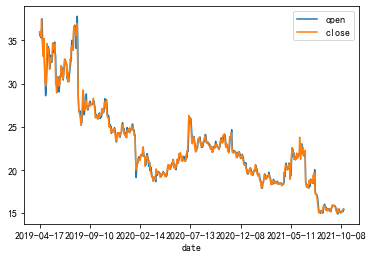

In [64]:
# data1=pd.DataFrame(data,columns=["trade_date","close"])
#data1=pd.DataFrame(data,columns=["close"])
data1=data.iloc[::-1]
data1["open"].plot(label="open")
data1["close"].plot(label="close")
plt.legend()
plt.show()


In [ ]:
ddd=[]
for item in data1.items():
    ddd.append(item)
ind=ddd[0][1].values
da1=ddd[1][1].values
index1=[]
data2=[]
for item in ind:
    index1.append(item)
index1.reverse()
for item in da1:
    data2.append(item)
data2.reverse()
data1={'trade_date':index1,'close':data2}
stockdata=pd.DataFrame(data1)

stockdata.items    

In [47]:

training_set = data1.iloc[0:512, 1:2]
test_set     = data1.iloc[606 - 300:, 1:2]
#将数据归一化，范围是0到1
sc  = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled  = sc.transform(test_set) 


In [55]:
# 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        
        if end_ix > len(sequence)-1:
            break
            
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train          = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test   = data_split(testing_set_scaled, n_timestamp)
X_test           = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [56]:
#五、构建模型
# 建构 LSTM模型
model_type=3
if model_type == 1:
    # 单层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                   input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
if model_type == 2:
    # 多层 LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                   input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # 双向 LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                            input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()  # 输出模型结构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
#七、训练模型
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)  # 测试的epoch间隔数

model.summary()

Epoch 1/20
8/8 [==============================] - 3s 100ms/step - loss: 0.0866 - val_loss: 0.0162
Epoch 2/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0486 - val_loss: 0.0150
Epoch 3/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0215 - val_loss: 0.0234
Epoch 4/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0137 - val_loss: 0.0245
Epoch 5/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0112 - val_loss: 0.0161
Epoch 6/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0100 - val_loss: 0.0137
Epoch 7/20
8/8 [==============================] - 0s 44ms/step - loss: 0.0090 - val_loss: 0.0125
Epoch 8/20
8/8 [==============================] - 0s 44ms/step - loss: 0.0085 - val_loss: 0.0103
Epoch 9/20
8/8 [==============================] - 0s 41ms/step - loss: 0.0082 - val_loss: 0.0101
Epoch 10/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 11/20
8/8 [===========

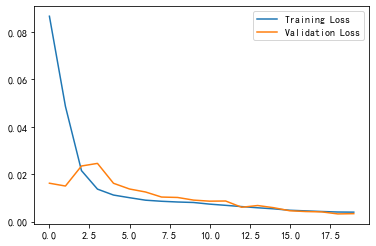

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [59]:
predicted_stock_price = model.predict(
    X_test)                        # 测试集输入模型进行预测
predicted_stock_price = sc.inverse_transform(
    predicted_stock_price)  # 对预测数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test)  # 对真实数据还原---从（0，1）反归一化到原始范围

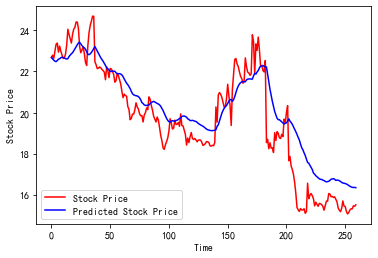

In [60]:
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [61]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f' % MSE)
print('均方根误差: %.5f' % RMSE)
print('平均绝对误差: %.5f' % MAE)
print('R2: %.5f' % R2)

均方误差: 1.40783
均方根误差: 1.18652
平均绝对误差: 0.93228
R2: 0.64628
